In [1]:
from gates import *
from states import *
from measurements import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
batch_size = 128
n_photons = 20
num_params = 5
num_iteration = 1000
initial_state = np.zeros((batch_size, n_photons))
initial_state[:, 0] = 1.
gate2 = S_gate(np.array([0.5]), np.array([0.]) , n_photons) 
gate3 = D_gate(np.array([-0.1]), np.array([0.]), n_photons)
state = np.einsum('ijk,ik->ij', gate2, initial_state)
initial_state = np.einsum('ijk,ik->ij', gate3, state)
# gamma, r1, phi1, r2, phi2, theta1
params = 0.1*np.ones(num_params)
lr = 1e-2 # learning rate

Initial_state


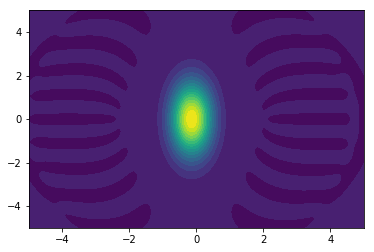

In [3]:
print("Initial_state")
init_state = initial_state[0]
init_state = init_state.reshape(init_state.shape[0],1)
rho = np.kron(init_state,init_state.conj().T)
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [4]:
def circuit(init_state, params, batch_size, num_params, lr, n_photons):
    random_numbers = lr*np.random.randn(num_params*batch_size).reshape(batch_size, num_params)
    
    gate2 = S_gate(params[0] + random_numbers[:,0], params[1] + random_numbers[:,1], n_photons) # squeezing
    gate3 = D_gate(params[2] + random_numbers[:,2], params[3] + random_numbers[:,3], n_photons) # displacement
    gate4 = R_gate(params[4] + random_numbers[:,4], n_photons) # rotation
    
    state = np.einsum('ijk,ik->ij', gate2, init_state)
    state = np.einsum('ijk,ik->ij', gate3, state)
    state = np.einsum('ijk,ik->ij', gate4, state)
    
    data_X = meas_X(state, n_photons)
    data_P = meas_P(state, n_photons)
    return random_numbers, data_X, data_P

def mean_moment(quadrature):
    return np.mean(quadrature, axis=1)

def calc_loss(X, P):
    X_mean = mean_moment(X)
    P_mean = mean_moment(P)
    return X_mean**2 + P_mean**2 # + P_mean**4 + X_mean**4


In [5]:
for i in range(num_iteration):
    lr = lr *0.99
    rand_num, X, P = circuit(initial_state, params, batch_size, num_params, lr, n_photons)
    loss = calc_loss(X, P)
    if i%10 ==0: print("Iteration = {} --- loss_value {}".format(i, np.mean(loss)))
    loss = (loss - np.mean(loss))/(np.std(loss)+1e-8)
    for j in range(num_params):
        params[j] -= lr/batch_size*loss.dot(rand_num[:,j])

Iteration = 0 --- loss_value 0.0007616695844262738
Iteration = 10 --- loss_value 0.0007442337871325228
Iteration = 20 --- loss_value 0.0007006283385187734
Iteration = 30 --- loss_value 0.0006196562111075216
Iteration = 40 --- loss_value 0.0005872897423000198
Iteration = 50 --- loss_value 0.0005972590545900212
Iteration = 60 --- loss_value 0.000543884506756271
Iteration = 70 --- loss_value 0.0005145496082637693
Iteration = 80 --- loss_value 0.0005658741653062707
Iteration = 90 --- loss_value 0.0005487918678125204
Iteration = 100 --- loss_value 0.0005900564517200209
Iteration = 110 --- loss_value 0.0005302725351037705
Iteration = 120 --- loss_value 0.0004435393484950191
Iteration = 130 --- loss_value 0.0005627750714175203
Iteration = 140 --- loss_value 0.0004839806863162694
Iteration = 150 --- loss_value 0.0005723288284212717
Iteration = 160 --- loss_value 0.0006052255180712725
Iteration = 170 --- loss_value 0.00054369066194002
Iteration = 180 --- loss_value 0.0005084678368675203
Iterati

KeyboardInterrupt: 

In [32]:
params = 0.1*np.ones(num_params)
params[0] = 0.5
params[1] = np.pi
params[2] = 0.1
params[3] = 0.
params[4] = 0.

In [33]:
def test(params, init_state):
    gate2 = S_gate(params[0], params[1], n_photons) # squeezing
    gate3 = D_gate(params[2], params[3], n_photons) # displacement
    gate4 = R_gate(params[4], n_photons) # rotation
    state = np.einsum('ijk,ik->ij', gate2, init_state)
    state = np.einsum('ijk,ik->ij', gate3, state)
    state = np.einsum('ijk,ik->ij', gate4, state)
    return state[0].reshape(state.shape[1],1)

In [34]:
new_state = test(params, initial_state)
rho = np.kron(new_state,new_state.conj().T)

Final_state


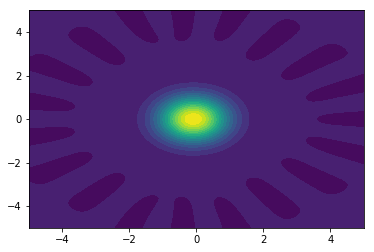

In [35]:
print("Final_state")
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [23]:
params

array([0.5       , 3.14159265, 0.1       , 0.        , 0.        ])